In [20]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from gpytorch.kernels import MaternKernel
np.random.seed(42)
torch.manual_seed(42)
global_dtype = torch.float64
device ='cpu'

### 1. Introduction

---

In this notebook we explore an alternative route for solving the regression problem based on convex optimization in a reproducing kernel hilbert space . We take the same toy example from the GP example in notebook 1 

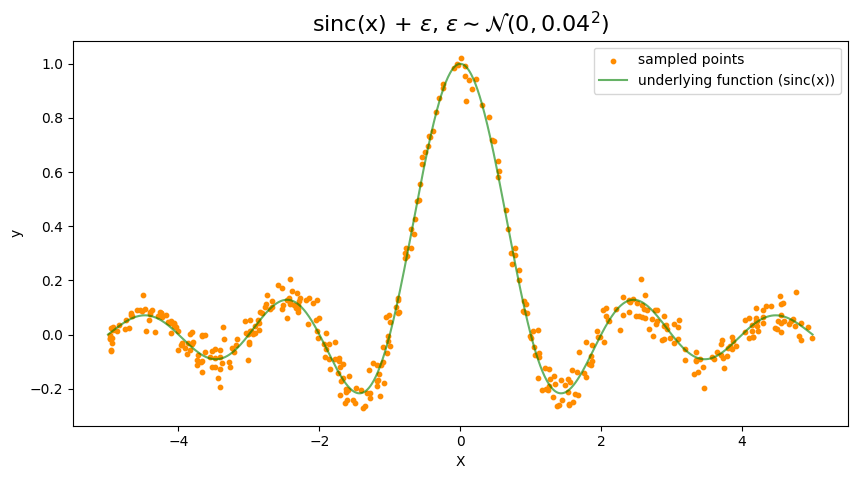

In [21]:
def underlying_function(X):
    base_function = torch.sinc(X)
    noise_std = 0.04
    noise = noise_std * torch.randn_like(X)
    return base_function + noise

n_samples = 400

train_data = torch.sort(10 * torch.rand(n_samples, 1) - 5)[0]
train_labels = underlying_function(train_data)

test_data = torch.linspace(-5, 5, 1000).unsqueeze(1)
test_labels_with_noise = underlying_function(test_data)
test_labels = torch.sinc(test_data)

plt.figure(figsize=(10, 5))
plt.scatter(train_data.numpy(), train_labels.numpy(), color='darkorange',s=10, label='sampled points')
plt.plot(test_data.numpy(), test_labels.numpy(), color='green', alpha=0.6, label='underlying function (sinc(x))')
plt.xlabel('X')
plt.ylabel('y')
plt.title(r'sinc(x) + $\epsilon$, $\epsilon \sim \mathcal{N}(0, 0.04^2)$', fontsize=16)
plt.legend()
plt.show()


### 2. Basic Kernel Ridge Regression (KRR)

---

KRR is an approach to regression using a kernel $k$ and its RKHS $\mathcal{H}_k$. The KRR estimator $\hat{f}$ of the regression function $f_0$  is defined as the solution of the following regularized least-squares problem
$$\hat{f}=\underset{f \in \mathcal{H}_k}{\operatorname{argmin}} \frac{1}{n} \sum_{i=1}^n\left(y_i-f\left(x_i\right)\right)^2+\lambda\|f\|_{\mathcal{H}_k}^2$$
 the solution $\hat{f}$ is given as a linear combination of $ k\left(\cdot, x_1\right)  {, }\ldots, k\left(\cdot, x_n\right)$
$$\hat{f}=\sum_{i=1}^n \alpha_i k\left(\cdot, x_i\right), \quad \text { with } \quad \alpha:=\left(\alpha_1, \ldots, \alpha_n\right)^{\top}:=\left(k_{X X}+n \lambda I_n\right)^{-1} y \in \mathbb{R}^n$$
With explicit form representable as 
$$
\hat{f}(x)=k_X(x)^{\top} \alpha=k_X(x)^{\top}\left(k_{X X}+n \lambda I_n\right)^{-1} y,
$$



In [22]:
sigma=.05
_lambda=sigma**2/train_data.shape[0]
lengthscale = .01

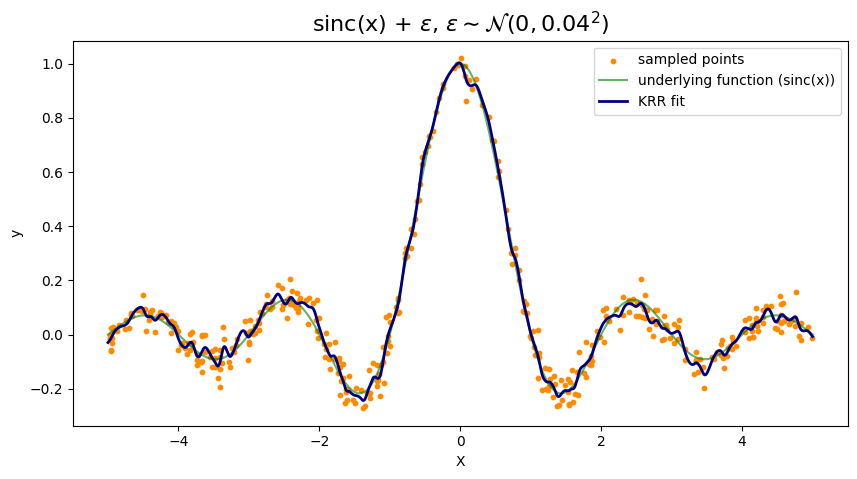

In [24]:
class KernelRidgeRegression:
    def __init__(self, _lambda=1.0, lengthscale=0.1, kernel=None, dtype=torch.float32):
        self._lambda = _lambda
        self.kernel = kernel(nu=1.5, lengthscale=lengthscale)
        self.dtype = dtype

    def fit(self, X, y):
        self.X_train = X.to(self.dtype)
        y = y.to(self.dtype)
        K = self.kernel(X, X).to(self.dtype)
        n = K.shape[0]
        self.alpha_vector = torch.linalg.solve(K + self._lambda * n * torch.eye(n, dtype=self.dtype), y)

    def predict(self, X):
        K = self.kernel(X.to(self.dtype), self.X_train).to(self.dtype)
        return torch.matmul(K, self.alpha_vector)

krr = KernelRidgeRegression(_lambda=_lambda, lengthscale=lengthscale, kernel=MaternKernel, dtype=global_dtype)
krr.fit(train_data, train_labels)
Krr_preds = krr.predict(test_data)
Krr_preds = Krr_preds.detach().numpy()

plt.figure(figsize=(10, 5))
plt.scatter(train_data.numpy(), train_labels.numpy(), color='darkorange', s=10, label='sampled points')
plt.plot(test_data.numpy(), test_labels.numpy(), color='green', alpha=0.6, label='underlying function (sinc(x))')
plt.plot(test_data.numpy(), Krr_preds, color='navy', lw=2, label='KRR fit')
plt.xlabel('X')
plt.ylabel('y')
plt.title(r'sinc(x) + $\epsilon$, $\epsilon \sim \mathcal{N}(0, 0.04^2)$', fontsize=16)
plt.legend()
plt.show()
